In [1]:
%matplotlib inline
!pip install nltk
!pip install seaborn
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
con = sqlite3.connect('database.sqlite') 

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
selected_data=pd.read_sql("select * from reviews",con)

In [3]:
selected_data.shape

(568454, 10)

In [4]:
selected_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Understanding of data:

### 1. Helpful numerator should be less than or equal to helfulness denominator..
### 2. Make sure that the same user cannot give the review for different products at the same unix time stamp..


In [5]:
### Trying out some queries..
number_of_unique_users=pd.value_counts(selected_data['UserId'])
print("Total_no_of_unique_users {}".format(len(number_of_unique_users)))

Total_no_of_unique_users 256059


In [6]:
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

In [7]:
filtered_data.shape

(525814, 10)

In [8]:
def conversion_from_review_to_string(review):
    if review==4 or review==5:
        return 'positive'
    else:
        return 'negative'

In [9]:
## Trying to remove score column and replace it by +/- string..
filtered_data['Score']=filtered_data['Score'].map(conversion_from_review_to_string)

In [10]:
score=filtered_data['Score']
score.shape

(525814,)

In [11]:
filtered_data.drop('Score',axis=1,inplace=True)

In [12]:
filtered_data.shape

(525814, 9)

In [13]:
filtered_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text'],
      dtype='object')

## DataCleaning...

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


### Here the user geetakrishna has given same review for different products at same time which needes to be deduped...

In [15]:
filtered_data=filtered_data.sort_values('ProductId',axis=0)
past_data_size=filtered_data.shape[0]
past_data_size

525814

In [16]:
filtered_data.drop_duplicates({'ProductId','UserId','ProfileName','Text'},inplace=True)
print(filtered_data.shape)
new_data_shape=filtered_data.shape[0]

(524587, 9)


In [17]:
data_loss=(past_data_size-new_data_shape)
print("Number of such duplicates are {}".format(data_loss))

Number of such duplicates are 1227


In [18]:
filtered_data=filtered_data[filtered_data.HelpfulnessNumerator<=filtered_data.HelpfulnessDenominator]

In [19]:
### So we have such duplicates this will affect the performance of the classifier
### Calculation the number of positive and negative reviews..
score.value_counts()

positive    443777
negative     82037
Name: Score, dtype: int64

## This is definitely an imbalanced dataset...

## Goal of the review is given a text we need to say whether a review is positive or not ..
### Applying the techniques of machine learning and natural language processing to solve this problem..

In [20]:
filtered_data['Text'][10]

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!"

## Text-Preprocessing..

### 1. Remove html tags as our text contains html tags..
### 2. Remove unnecessary punctuations..
### 3. Remove all the alphanumeric characters which do not help us in any way...
### 4. Remove words that has string length less than 2.
### 5. Remove stop words..
### 6. Apply stemming using snowball stemmer..
### 7. Finally lematize the word and lower it before adding in to clean text documnet...

In [21]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"won't", 'a', 'wouldn', 'into', "you'd", 'down', 'or', 'both', "doesn't", 'too', 'while', 'with', 'during', 'same', 'hers', 'through', 'other', 'most', 'can', 'o', 'isn', "wouldn't", 'for', "shan't", 'just', "she's", 'of', 'yourselves', "didn't", "should've", 're', 'hasn', "mustn't", 'by', 'd', 'they', 'the', 'than', 'ours', 'he', 'ain', 'was', 'some', 'between', 'below', 'himself', 'when', 'we', "hasn't", 'once', 'i', "mightn't", 'been', 'that', 'theirs', 'such', 'until', "you're", 'all', 'me', "aren't", 'mightn', 'has', 'needn', 'haven', 'which', 'them', 'it', 'if', 'few', 'did', 'their', 'off', 'not', 'him', 's', 'here', 'weren', 'doesn', 'does', 'an', 'is', 'itself', 'our', 'then', 'about', "weren't", 'on', 'having', 'her', 'his', 'from', "you'll", 'ma', "that'll", "don't", 'you', 'have', 'y', 'will', 'mustn', 'after', 'should', 'under', 'am', 'only', 'now', 'she', "haven't", 'as', 'to', "it's", 'yourself', 'each', 'my', "shouldn't", "wasn't", 'herself', 'were', 'at', 'had', 'and'

In [22]:
len(score)

525814

In [23]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in filtered_data['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (score[i]) == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(score[i]) == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    final_string.append(str1)
    i+=1

In [24]:
filtered_data['CleanedText']=final_string 

In [25]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [26]:
filtered_data.drop('Text',axis=1,inplace=True)

In [27]:
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,939340800,EVERY book is educational,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1194739200,"Love the book, miss the hard cover version",b'grew read sendak book watch realli rosi movi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1191456000,chicken soup with rice months,b'fun way children learn month year learn poem...


In [28]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
filtered_data.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [29]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(filtered_data['CleanedText'].values)
type(final_counts)
final_counts.get_shape()

(524585, 71624)

In [30]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(filtered_data['CleanedText'].values)
final_bigram_counts.get_shape()

Most Common Positive Words :  [(b'like', 214979), (b'tast', 196512), (b'flavor', 163108), (b'good', 155000), (b'love', 149971), (b'one', 146669), (b'product', 139316), (b'use', 135072), (b'great', 134395), (b'coffe', 130141), (b'tri', 129229), (b'tea', 117975), (b'food', 115796), (b'get', 107165), (b'make', 97161), (b'would', 90400), (b'dog', 82796), (b'buy', 81736), (b'eat', 80808), (b'time', 78835)]
Most Common Negative Words :  [(b'like', 39467), (b'tast', 36227), (b'flavor', 30526), (b'good', 28477), (b'love', 27951), (b'one', 27142), (b'product', 25645), (b'coffe', 24960), (b'use', 24893), (b'great', 24781), (b'tri', 24003), (b'tea', 22291), (b'food', 21782), (b'get', 19803), (b'make', 17979), (b'would', 16548), (b'dog', 15188), (b'buy', 15097), (b'eat', 14819), (b'time', 14526)]


(524585, 2923725)

In [31]:
from sklearn.manifold import TSNE
X = TSNE(n_components=2).fit_transform(final_counts[:5000].todense())

In [32]:
X.shape

(5000, 2)

In [38]:
tsne_data=np.c_[X,score[:5000]]
tsne_data.shape

(5000, 3)

### The below visualization i acquired for only 5000 point because of memory error..

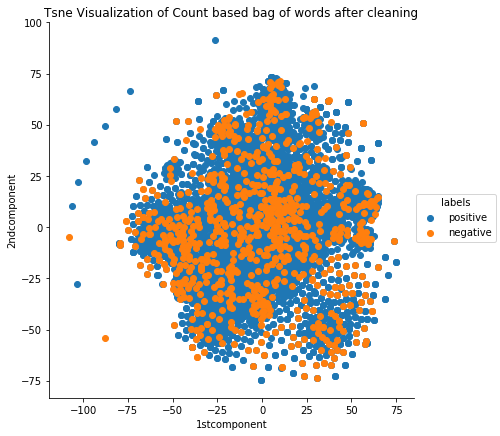

In [42]:
tsne_data=pd.DataFrame(tsne_data,columns=("1stcomponent","2ndcomponent","labels"))
import seaborn as sns
sns.FacetGrid(tsne_data,hue="labels",size=6).map(plt.scatter,"1stcomponent","2ndcomponent").add_legend()
plt.title("Tsne Visualization of Count based bag of words after cleaning")
plt.show()